In [1]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams

### Define the problem

In [74]:
# want to create a model with some fixed parameters

# create the variables
p = dof2.FwtParameters.Default2DoF() # parameter container

mass_ratio = 4                    # mass ratio between wing and FWT
p.m_w = dof2.FwtVariable(4,'m_w')   # mass of inner wing
wing_freq = 2                       # freq of inner wing

# set values for independent symbols
p.s.value = 1
p.c.value = 0.15
p.g.value = 9.81
p.rho.value = 1.225
p.a_t.value = 2 * np.pi
p.alpha_r.value = np.deg2rad(5)
p.Lambda.value = np.deg2rad(-10)

# set expression for dependent symbols
p.k = (sym.Integer(wing_freq)*2*sym.pi)**2*(p.m_w+p.m_w/sym.Float(mass_ratio))
p.m = p.m_w/sym.Integer(mass_ratio)
p.I_xx = sym.Rational(1,12)*p.m*p.s**2*1
p.l = p.s*sym.Rational(2,4)

# potential Energy
half = sym.Rational(1,2)
U = p.m*p.g*(-p.l*sym.cos(p.q[0])) + half*p.k*(p.q[1])**2

# Create Point masses

# Transform for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_x(-sym.pi*sym.Rational(1,2)+p.q[0])
fwt_com_frame = fwt_frame.Translate(0,p.l,0)
rot = sym.Matrix([-sym.pi*sym.Rational(1,2)+p.q[0],0,0])


mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)


M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)

m = dof2.RigidElement(fwt_com_frame,rot,M_fwt)


# Aero Forces
AeroForces = ams.SimpleAeroModel(p,fwt_frame,at_mode=1)
me.mechanics_printing()


sm = dof2.SymbolicModel(U,[mw,m],p,ExtForces = AeroForces)

### Determine the fixed points of this system

In [75]:
# create data for the cruise angle for 3 different root AoA
thetas = np.linspace(0,np.pi,361)
aoa = [0,2.5,5,7.5,10]
df = pd.DataFrame()
TestConditions = pd.DataFrame()
funcs=[]

TestConditions['theta'] = np.linspace(0,np.pi,361)
for i in aoa:
    mdf = TestConditions.copy()
    mdf['alpha'] = i
    p.alpha_r.value = np.deg2rad(i)
    cruiseV = sm.CruiseAngleEqn(p,AeroForces)
    funcs.append(cruiseV)
    V,q1s = cruiseV(thetas)
    mdf['V'] = V
    mdf['q1_stat'] = q1s
    df = df.append(mdf, sort=False)

<string>:2: RuntimeWarning: invalid value encountered in sqrt
<string>:2: RuntimeWarning: invalid value encountered in sqrt
<string>:2: RuntimeWarning: invalid value encountered in sqrt
<string>:2: RuntimeWarning: invalid value encountered in sqrt
<string>:2: RuntimeWarning: invalid value encountered in sqrt


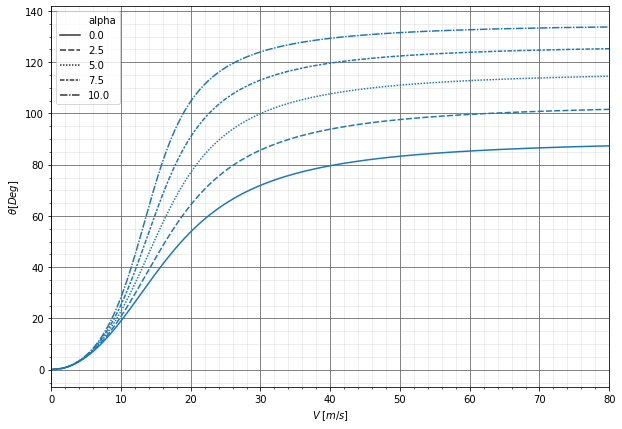

In [76]:
# plot the data
fig, axes = plt.subplots(1,1,figsize=(10,7))
df[r'$\theta [Deg]$']= np.rad2deg(df['theta'])
df[r'$V\; [m/s]$']= df['V']
sns.lineplot(data=df,y=r'$\theta [Deg]$',x=r'$V\; [m/s]$',style='alpha',ax=axes)
axes.set(xlim=(0,80))
axes.grid(b=True, which='major', color='#666666', linestyle='-')
axes.minorticks_on()
axes.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

In [77]:
# get the velocity where thecruise angle is pi/2 (parallel)
df[df['theta']==np.pi/2]

,theta,alpha,V,q1_stat,$\theta [Deg]$,$V\; [m/s]$
180,1.570796,0.0,2.189682e+09,0.018637,90.0,2.189682e+09
180,1.570796,2.5,3.419287e+01,0.018637,90.0,3.419287e+01
180,1.570796,5.0,2.420094e+01,0.018637,90.0,2.420094e+01
180,1.570796,7.5,1.979103e+01,0.018637,90.0,1.979103e+01
180,1.570796,10.0,1.717688e+01,0.018637,90.0,1.717688e+01


### Linearise the system about some fixed points

In [78]:
# and function to sub in a time dependent variable without altering its derivatives
def msub(expr,v,sub,derivatives):
    temps = list(sym.symbols(f'temps:{derivatives}'))
    derivs = list(sym.symbols(f'temps:{derivatives+1}'))
    derivs[0] = v
    for i in range(1,derivatives+1):
        derivs[i]=derivs[i-1].diff(me.dynamicsymbols._t)
        
    expr = expr.subs({derivs[i]:temps[i-1] for i in range(1,derivatives+1)})
    expr = expr.subs(v,sub)
    expr = expr.subs({temps[i-1]:derivs[i] for i in range(1,derivatives+1)})
    return expr     

In [79]:
df['theta'].iloc[0]

In [85]:
# create complete EoM
EoM = sm.X.subs({sm.F[0]:AeroForces.Q[0],sm.F[1]:AeroForces.Q[1]})

# sub all in but velocity
tup = p.GetTuple(ignore=['V','alpha_r'])
eqs = sym.simplify(EoM.subs({v:v.value for v in tup}))

#calculate the jacobian
jac = eqs.jacobian(p.x)

In [155]:
#create linear freq/damping plots about each of the fixed points
TestConditions = pd.DataFrame()
TestConditions['V'] = np.linspace(0,50,51)
flutdf = pd.DataFrame()

for a in [2.5,5,7.5,10]:
    condition = df[(df['alpha']==a) & (df['theta']==np.pi/2)]
       
    # the fixed point to linearise about
    lp = [4*np.pi/8+np.deg2rad(0),0,condition['q1_stat'].iloc[0],0]
    
    # get the jacobian about this point
    jac_f = msub(jac,p.q[0],lp[0],2)
    jac_f = msub(jac_f,p.q[1],lp[2],2)

    jac_f = msub(jac_f,p.qd[0],lp[1],1)
    jac_f = msub(jac_f,p.qd[1],lp[3],1)
    
    #sub in alpha
    jac_ff = jac_f.subs(p.alpha_r,a)
    print(a)

    #turn the jacobian into a function of V
    func = sym.lambdify((p.V),jac_ff)
    
    # get the modes
    for i in TestConditions['V']:       
        evals,evecs = np.linalg.eig(func(i))
        # get unique modes
        e_vals_unique_imag = []
        e_vals_unique_real = []
        mode = []
        for j in evals:
            if np.imag(j)!=0:
                if np.abs(np.imag(j)) not in np.imag(e_vals_unique_imag):
                    e_vals_unique_imag.append(np.abs(np.imag(j)))
                    e_vals_unique_real.append(np.real(j))
                    mode.append(len(mode))
        df_v = pd.DataFrame()
        df_v['Mode'] = mode
        df_v['cn'] = np.array(e_vals_unique_real) + 1j * np.array(e_vals_unique_imag)
        df_v['Frequency'] = np.abs(df_v['cn'])
        df_v['Damping'] = np.cos(np.angle(df_v['cn']))
        df_v['V'] = i
        df_v['aoa'] = a
        flutdf = flutdf.append(df_v,sort=False)
my_func = sym.lambdify((p.V,p.alpha_r),jac_f.simplify())

2.5
5
7.5
10


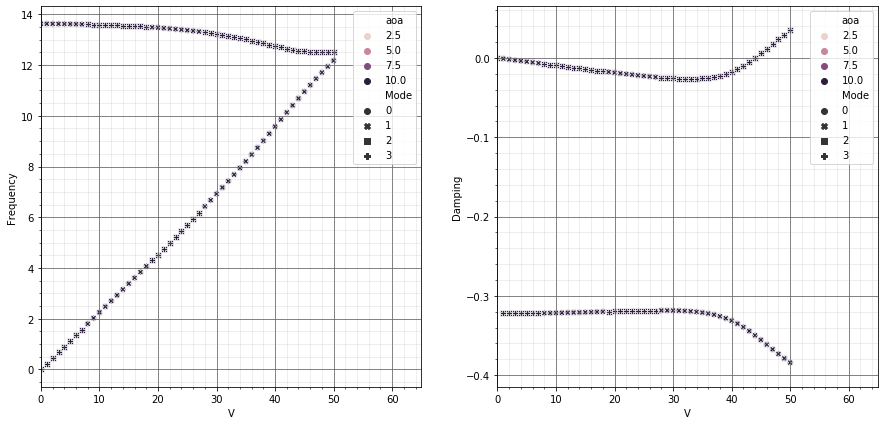

In [156]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
data = flutdf[(flutdf['Damping']<0)]
data = flutdf
fig, axes = plt.subplots(1,2,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='aoa',style='Mode',ax=axes[0])
sns.scatterplot(data=data,x='V',y='Damping',hue='aoa',style='Mode',ax=axes[1])

for i in [0,1]:
    axes[i].set(xlim=(0,80))
    axes[i].grid(b=True, which='major', color='#666666', linestyle='-')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,65))

In [162]:
# create complete EoM
EoM = sm.X.subs({sm.F[0]:AeroForces.Q[0],sm.F[1]:AeroForces.Q[1]})

# sub all in but velocity
tup = p.GetTuple(ignore=['V','alpha_r'])
eqs = sym.simplify(EoM.subs({v:v.value for v in tup}))

#calculate the jacobian
jac = eqs.jacobian(p.x)

# function to linearise jacobian
lp = sym.Matrix(sym.symbols('lp:4'))

jac_f = msub(jac,p.q[0],lp[0],2)
jac_f = msub(jac_f,p.q[1],lp[2],2)

jac_f = msub(jac_f,p.qd[0],lp[1],1)
jac_f = msub(jac_f,p.qd[1],lp[3],1)

func = sym.lambdify((p.V,p.alpha_r,lp),jac_f)

In [163]:
flutdfv2 = pd.DataFrame()
for a in df['alpha'].unique():
    #get relevent data points
    data = df[(df['alpha']==a) & (df['V']<60) & (df['V']>15)]
    for i in range(0,len(data)):
        # get the static position
        lp = [data['theta'].iloc[i],0,data['q1_stat'].iloc[i],0]
        # get the jacobian evaluated at this point
        j_lp = func(data['V'].iloc[i],a,lp)
        # get eigen values of this jacobian       
        evals,evecs = np.linalg.eig(j_lp)
        
        # get unique modes
        e_vals_unique_imag = []
        e_vals_unique_real = []
        mode = []
        for j in evals:
            if np.imag(j)!=0:
                if np.abs(np.imag(j)) not in np.imag(e_vals_unique_imag):
                    e_vals_unique_imag.append(np.abs(np.imag(j)))
                    e_vals_unique_real.append(np.real(j))
                    mode.append(len(mode))
        if np.max(e_vals_unique_real)<0:
            df_v = pd.DataFrame()
            df_v['Mode'] = mode
            df_v['cn'] = np.array(e_vals_unique_real) + 1j * np.array(e_vals_unique_imag)
            df_v['Frequency'] = np.abs(df_v['cn'])/(2*np.pi)
            df_v['Damping'] = np.cos(np.angle(df_v['cn']))
            df_v['V'] = data['V'].iloc[i]
            df_v['aoa'] = a
            flutdfv2 = flutdfv2.append(df_v,sort=False)
        

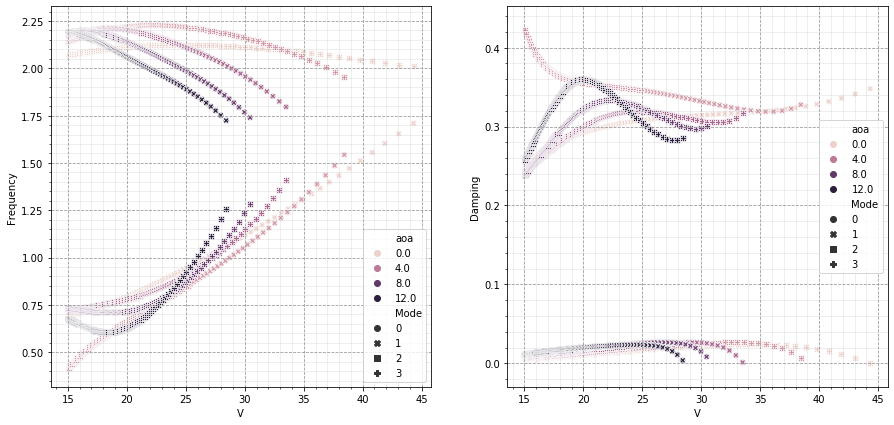

In [165]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
data = flutdfv2[(flutdfv2['Damping']>0)]
#data = flutdfv2
fig, axes = plt.subplots(1,2,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='aoa',style='Mode',ax=axes[0])
sns.scatterplot(data=data,x='V',y='Damping',hue='aoa',style='Mode',ax=axes[1])
for i in [0,1]:
    #axes[i].set(xlim=(0,80))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

In [136]:
e_vals_unique_real

In [114]:
jac = eqs.jacobian(p.x)

jac = msub(jac,p.q[0],lp[0],2)
jac = msub(jac,p.q[1],lp[2],2)

jac = msub(jac,p.qd[0],lp[1],1)
jac = msub(jac,p.qd[1],lp[3],1)
jac


func = sym.lambdify((p.V),jac)
np.linalg.eig(func(44))

(array([-3.73828997e+00+10.01040246j, -3.73828997e+00-10.01040246j,
         3.02870098e-03+12.56496046j,  3.02870098e-03-12.56496046j]),
 array([[-3.24456298e-02-0.08688299j, -3.24456298e-02+0.08688299j,
          1.80412089e-05-0.0748463j ,  1.80412089e-05+0.0748463j ],
        [ 9.91024875e-01+0.j        ,  9.91024875e-01-0.j        ,
          9.40440916e-01+0.j        ,  9.40440916e-01-0.j        ],
        [-3.84874707e-03+0.00810267j, -3.84874707e-03-0.00810267j,
          8.43329500e-03+0.02492063j,  8.43329500e-03-0.02492063j],
        [-6.67232422e-02-0.06881763j, -6.67232422e-02+0.06881763j,
         -3.13101232e-01+0.1060395j , -3.13101232e-01-0.1060395j ]]))

In [115]:

lin_eq

⎡                      2                      ⎤
⎢- 0.0519316151104491⋅V  + 0.453384952175042⋅V⎥
⎢                                             ⎥
⎢             2                               ⎥
⎣       16.0⋅π ⋅q₁ + 0.740220330081702        ⎦

In [117]:
tmax, dt = 5, 0.01
# Initial conditions: theta, dtheta/dt, L, dL/dt

#set velocity and alpha_r funcs
def Vfunc(t):
    return 24

def arfunc(t):
    return np.deg2rad(5)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)

AeroForces.SetFuncs(p,Vfunc,arfunc)

y0 = [0,0,-0.05,0]
#y0 = [1.5,0,0.02,0]
yData = solve_ivp(lambda t,y:sm.deriv(t,y,p),(0,tmax),y0,max_step=dt)

# interpolate data onto a uniform time grid
t = np.arange(0, tmax+dt, 0.01)
yi = np.zeros((len(t),len(y0)+2)).T
for i in range(0,len(y0)):
    yi[i] = np.interp(t,yData.t,yData.y[i])
for i in range(0,2):
    yd = sm.deriv(0,yi[:4,:],p)
    yi[i+4,:] = yd[1]
    yi[i+4,:] = yd[3]

plt.style.use('seaborn-white')
    
fig, axes = plt.subplots(3,2,figsize=(15,5))

# d plot
axes[0][0].plot(t,yi[2])
axes[0][0].set_ylabel('d [m]')
axes[0][0].set_xlabel('t [s]')

# theta plot
axes[0][1].plot(t,yi[0])
axes[0][1].set_ylabel('$\theta$ [rad]')
axes[0][1].set_xlabel('t [s]')


# ddot plot
axes[1][0].plot(t,yi[3])
axes[1][0].set_ylabel('$\dot{d}$ [m/s]')
axes[1][0].set_xlabel('t [s]')

# thetadot plot
axes[1][1].plot(t,yi[1])
axes[1][1].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][1].set_xlabel('t [s]')

# ddot plot
axes[2][0].plot(t,yi[4])
axes[2][0].set_ylabel('$\ddot{d}$ [m/s]')
axes[2][0].set_xlabel('t [s]')

# thetadot plot
axes[2][1].plot(t,yi[5])
axes[2][1].set_ylabel(r'$\ddot{\theta}$ [rad/s]')
axes[2][1].set_xlabel('t [s]')

AttributeError: 'SimpleAeroModel' object has no attribute 'SetFuncs'

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.style.use(r'C:\Users\qe19391\OneDrive - University of Bristol\Documents\Projects\FWTD modelling\Styles\presentation.mplstyle')
   
fig, axes = plt.subplots(3,1,figsize=(15,12))
#fig.tight_layout()
# d plot
axes[0].plot(t,yi[2])
axes[0].set_ylabel('d [m]')
axes[0].set_xlabel('t [s]')

# theta plot
axes[1].plot(t,yi[0])
axes[1].set_ylabel(r'$\theta$ [rad]')
axes[1].set_xlabel('t [s]')

# energy
qs,qds = sm._getStates(yi)
tup = p.GetNumericTuple()
vs = Vfunc(t)
ars = arfunc(t)

alphas = AeroForces.GetAlpha(p,qs,qds,1,t)

l1, = axes[2].plot(t,np.rad2deg(AeroForces.GetAlpha(p,qs,qds,1,t)))
l2, = axes[2].plot(t,np.rad2deg(AeroForces.GetAlpha(p,qs,qds,0.5,t)))
l3, = axes[2].plot(t,np.rad2deg(AeroForces.GetAlpha(p,qs,qds,0,t)))
l4, = axes[2].plot(t,np.rad2deg(AeroForces.GetAlpha(p,qs,[0,0],0,t)))
l1.set_label('Tip')
l2.set_label('Mid-span')
l3.set_label('Root')
l4.set_label('Geometric')
axes[2].legend()
axes[2].set_ylabel(r'$\alpha_h(y_t)$')
axes[2].set_xlabel('t [s]')
#axes[3][0].set_ylim(0.5,1.5)
PhotoDir = r'C:\Users\qe19391\OneDrive - University of Bristol\Documents\Projects\FWTD modelling\Videos & Photos'+'\\'
plt.savefig(PhotoDir + r'ModelStates.png',transparent=True,bbox_inches='tight')

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\qe19391\OneDrive - University of Bristol\Documents\Programs\ffmpeg-20200211-f15007a\bin\ffmpeg.exe'

spring_size = 0.5
fig = plt.figure()
ax = plt.axes(xlim=(-1.2,1.2),ylim=(-1.2,1.2))
ax.axis('equal')
ax.set()
fwt, = ax.plot([],[],'ro-')
spring = cpo.Spring.FromLengthAndAngle(np.pi/2,p.s.value,ax = ax)

# initialization function 
def init(): 
    # creating an empty plot/frame 
    spring.ReplotSpring((0,0),np.pi,1+y0[2])
    fwt.set_data([0,p.s.value],[1,1])
    return spring.springObj,fwt
                    
def animate(i):
    theta = yi[0,i]
    d = yi[2,i]
    spring.ReplotSpring((0,0),np.pi,d+spring_size)
    fwt.set_data([0,p.s.value*np.sin(theta)],[d+spring_size,-p.s.value*np.cos(theta)+d+spring_size])
    return spring.springObj,

plt.axis('off')    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=20, blit=True)
#anim.save(f'basic_animation_{test_case+1}.mp4', fps=30)
HTML(anim.to_html5_video())

In [21]:
sm.EoM

⎡      m_w⋅s⋅(3⋅g⋅sin(q₀) + 2⋅s⋅q₀̈ + 3⋅sin(q₀)⋅q₁̈)            ⎤
⎢      ─────────────────────────────────────────── - f₀       ⎥
⎢                           24                                ⎥
⎢                                                             ⎥
⎢    ⎛                           2          2           ⎞     ⎥
⎢m_w⋅⎝s⋅sin(q₀)⋅q₀̈ + s⋅cos(q₀)⋅q₀̇  + 160.0⋅π ⋅q₁ + 10⋅q₁̈⎠     ⎥
⎢──────────────────────────────────────────────────────── - f₁⎥
⎣                           8                                 ⎦

In [22]:
AeroForces.Q

⎡                                                        ⎛           2    2   
⎢                                                        ⎜  aₜ⋅c⋅ρ⋅Vₜ ⋅sin (q₀
⎢ 3 ⎛             2                       2       ⎞      ⎜                    
⎢s ⋅⎝aₜ⋅c⋅ρ⋅Vₜ⋅sin (q₀)⋅q₀̇ + aₜ⋅c⋅ρ⋅Vₜ⋅cos (q₀)⋅q₀̇⎠    2 ⎜                  
⎢────────────────────────────────────────────────── + s ⋅⎜- ──────────────────
⎢                        8                               ⎝                    
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                                                   